<a href="https://colab.research.google.com/github/btekgit/GaussianLayer/blob/master/GaussLayer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
# CODE for Gaussian Layer
!pwd

/content


In [0]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Feb 13 19:07:34 2018
LAst update Jun 17 2019

@author: btek
"""
from keras import backend as K
from keras.engine.topology import Layer
from keras.utils import conv_utils
from keras import activations, regularizers, constraints
from keras import initializers
from keras.engine import InputSpec
import numpy as np
import tensorflow as tf

In [0]:
def idx_init(shape, dtype='float32'):
    idxs = np.zeros((shape[0], shape[1]),dtype)
    c = 0
    # assumes square filters
    
    wid = np.int(np.sqrt(shape[0]))
    hei =np.int(np.sqrt(shape[0]))
    f = np.float32
    for x in np.arange(wid):  # / (self.incoming_width * 1.0):
        for y in np.arange(hei):  # / (self.incoming_height * 1.0):
            idxs[c, :] = np.array([x/f(wid-1), y/f(hei-1)],dtype)
            c += 1

    return idxs

def cov_init(shape, dtype='float32'):
    
    cov = np.identity(shape[1], dtype)
    # shape [0] must have self.incoming_channels * self.num_filters
    cov = np.repeat(cov[np.newaxis], shape[0], axis=0)
    
    #for t in range(shape[0]):
    #    cov[t] = cov[t]
    return cov

def scale_init(shape, dtype='float32'):
    #sc = np.linspace(0.5, 1.6, shape[0]) #best for mnist cluttered
    #sc = np.linspace(0.05, 0.1, shape[0],dtype=dtype) #best for mnist cluttered
    #sc = 0.05*np.ones(shape[0],dtype=dtype) #best for mnist cluttered
    sc = np.linspace(0.05, 0.1, shape[0],dtype=dtype)#tried on fashion mnist with no difference
    #sc=np.expand_dims(sc, axis=1)
    #sc=np.expand_dims(sc, axis=2)
    #print(sc)
    return sc

In [0]:
class GaussScaler(Layer):
    def __init__(self, rank, filters,
                 kernel_size,
                 strides=1,
                 padding='valid',
                 data_format=None,
                 dilation_rate=1,
                 activation=None,
                 use_bias=False,
                 kernel_regularizer=None,
                 gain=1.0,
                 output_padding=None,
                 **kwargs):
        super(GaussScaler, self).__init__(**kwargs)
        #def __init__(self, num_filters, kernel_size, incoming_channels=1, **kwargs):
        self.rank = rank
        self.filters = filters
        self.kernel_size = conv_utils.normalize_tuple(kernel_size, rank, 'kernel_size')
        self.strides = conv_utils.normalize_tuple(strides, rank, 'strides')
        self.padding = conv_utils.normalize_padding(padding)
        self.data_format = data_format
        self.dilation_rate = conv_utils.normalize_tuple(dilation_rate, rank, 'dilation_rate')
        self.activation = activations.get(activation)
        self.use_bias = use_bias
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.input_spec = InputSpec(ndim=self.rank + 2)
        self.gain = gain
                 
        #self.input_shape = input_shape
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'))
        print(kwargs)
        self.kernel_size = kernel_size
        
        self.num_filters = filters
        #self.incoming_channels = incoming_channels
        
        
        self.output_padding = output_padding
        if self.output_padding is not None:
            self.output_padding = conv_utils.normalize_tuple(
                self.output_padding, 2, 'output_padding')
            for stride, out_pad in zip(self.strides, self.output_padding):
                if out_pad >= stride:
                    raise ValueError('Stride ' + str(self.strides) + ' must be '
                                     'greater than output padding ' +str(self.output_padding))
                    
        super(GaussScaler, self).__init__(**kwargs)

    def build(self, input_shape):
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
        if input_shape[channel_axis] is None:
            raise ValueError('The channel dimension of the inputs '
                             'should be defined. Found `None`.')
        input_dim = input_shape[channel_axis]
        
        self.input_channels = input_dim
        kernel_shape = self.kernel_size + (input_dim, self.filters)
        print("kernel shape:",kernel_shape)

        self.bias = None
        # Set input spec.
        self.input_spec = InputSpec(ndim=self.rank + 2,
                                    axes={channel_axis: input_dim})
        self.built = True
        # Create a trainable weight variable for this layer.
        
        kernel_size = self.kernel_size
        # Idxs Init
        
        
        
        
        #mu = np.array([kernel_size[0] // 2, kernel_size[1] // 2])
        mu = np.array([0.5, 0.5])


        # Convert Types
        self.mu = mu.astype(dtype='float32')

        # Shared Parameters
        # below works for only two dimensional cov 
        #self.cov = self.add_weight(shape=[input_dim*self.filters,2,2], 
        #                          name="cov", initializer=cov_init, trainable=False)
        
        
        self.cov_scaler = self.add_weight(shape=(self.filters,),
                                          name='scaler',initializer=scale_init,
                                          trainable=True,
                                          constraint= constraints.NonNeg())
                                  #constraint=constraints.non_neg())
        
        #print("Self.cov:",self.cov)
        #print("Self cov-scaler",self.cov_scaler)
        
        # below prepares a meshgrid. 
        #self.idxs = self.add_weight(shape=[kernel_size[0]*kernel_size[1],2], 
        #                           name="idxs", initializer=idx_init, trainable=False)
        
        self.idxs= idx_init(shape=[kernel_size[0]*kernel_size[1],2])
        
        super(GaussScaler, self).build(input_shape)  # Be sure to call this somewhere!
        
    
    def U(self):
  
        e1 = (self.idxs - self.mu)
        #print("e1.shape",e1.shape)
        #print("cov scaler shape",self.cov_scaler)
   
        #print(self.cov.shape)
        #print(len(tf.unstack(self.cov,axis=0)))
        #print( tf.linalg.inv(tf.unstack(self.cov,axis=0)[0]))
        # tensorflow does not need scan it does the same op to all covs.
        #cov_inv = self.cov
        #cov_scaled =self.cov_scaler*self.cov
#        cov_scaled = tf.scalar_mul(self.cov_scaler,self.cov)
#        print(self.cov.shape, self.cov_scaler.shape )
#        cov_scaled = K.batch_dot(self.cov_scaler,self.cov, axes=[1,2])
        #cov_inv = tf.linalg.inv(cov_scaled)
        #print("cov_scaled :",cov_scaled.shape)
        #cov_inv = K.map_fn(lambda x: tf.linalg.inv(x), elems=tf.unstack(self.cov,axis=0))
       

        #e2 = K.dot(e1, K.transpose(cov_inv))
        #ex = K.batch_dot(e2, e1, axes=[[1], [1]])
        #result = K.exp(-(1 / 2.0) * ex)

        up= K.sum((self.idxs - self.mu)**2, axis=1)
        #print("up.shape",up.shape)
        up = K.expand_dims(up,axis=1,)
        #print("up.shape",up.shape)
        # clipping scaler in range to prevent div by 0 or negative cov. 
        cov_scaler = K.clip(self.cov_scaler,0.01,5)
        #cov_scaler = self.cov_scaler
        dwn = 2 * (cov_scaler ** 2)
        #scaler = (np.pi*self.cov_scaler**2) * (self.idxs.shape[0])
        result = K.exp(-up / dwn)
        


        # Transpose is super important.
        #filter: A 4-D `Tensor` with the same type as `value` and shape
        #`[height, width, output_channels, in_channels]`
        # we do not care about input channels
        
        masks = K.reshape(result,(self.kernel_size[0],
                                  self.kernel_size[1],
                                  self.filters,1))   
            
        #sum normalization each filter has sum 1
        #sums = K.sum(masks**2, axis=(0, 1), keepdims=True)
        #print(sums)
        #gain = K.constant(self.gain, dtype='float32')
        masks /= K.sqrt(K.sum(K.square(masks), axis=(0, 1),keepdims=True))
        #masks /= K.sum(masks, axis=(0, 1),keepdims=True)
        #masks /= (self.kernel_size[0]*self.kernel_size[1])
        
        #masks *= (gain*np.sqrt(self.kernel_size[0]*self.kernel_size[1]))
        #ums = sums * sums
        #print("sums shape: ", sums.shape)
        
        # Sum normalisation
        
        #masks = masks * (gain/K.sqrt(sums))
        #masks = masks * (gain/sums)
        #print("masks shape", masks.shape)
        #print("masks mask", K.mean(masks))
        return masks



    def call(self, inputs):
        input_shape = K.shape(inputs)
        batch_size = input_shape[0]
        if self.data_format == 'channels_first':
          h_axis, w_axis = 2, 3
          c_axis= 1
          
        else:
            h_axis, w_axis = 1, 2
            c_axis=3
            
        ##BTEK 
        kernel = self.U()
        in_channels =input_shape[c_axis]
        
        height, width = input_shape[h_axis], input_shape[w_axis]
        kernel_h, kernel_w = self.kernel_size
        stride_h, stride_w = self.strides
        if self.output_padding is None:
            out_pad_h = out_pad_w = None
        else:
            out_pad_h, out_pad_w = self.output_padding

        # Infer the dynamic output shape:
        out_height = conv_utils.deconv_length(height,
                                              stride_h, kernel_h,
                                              self.padding,
                                              out_pad_h,
                                              self.dilation_rate[0])
        out_width = conv_utils.deconv_length(width,
                                             stride_w, kernel_w,
                                             self.padding,
                                             out_pad_w,
                                             self.dilation_rate[1])
        if self.data_format == 'channels_first':
            output_shape = (batch_size, self.filters, out_height, out_width)
        else:
            output_shape = (batch_size, out_height, out_width, self.filters)

        ##BTEK 
        kernel = self.U()
        print("kernel shape in output:",kernel.shape)
        print("channel axis")
        kernel = K.repeat_elements(kernel, self.input_channels, axis=c_axis)
        print("kernel reshaped :",kernel.shape)
        #---------------------------------------------------------------------
        outputs = K.conv2d_transpose(
            inputs,
            kernel,
            output_shape,
            self.strides,
            padding=self.padding,
            data_format=self.data_format,
            dilation_rate=self.dilation_rate)

        if self.use_bias:
            outputs = K.bias_add(
                outputs,
                self.bias,
                data_format=self.data_format)

        if self.activation is not None:
            return self.activation(outputs)
        return outputs


        
    def compute_output_shape(self, input_shape):
        output_shape = list(input_shape)
        if self.data_format == 'channels_first':
            c_axis, h_axis, w_axis = 1, 2, 3
        else:
            c_axis, h_axis, w_axis = 3, 1, 2

        kernel_h, kernel_w = self.kernel_size
        stride_h, stride_w = self.strides
        if self.output_padding is None:
            out_pad_h = out_pad_w = None
        else:
            out_pad_h, out_pad_w = self.output_padding

        output_shape[c_axis] = self.filters
        output_shape[h_axis] = conv_utils.deconv_length(output_shape[h_axis],
                                                        stride_h,
                                                        kernel_h,
                                                        self.padding,
                                                        out_pad_h,
                                                        self.dilation_rate[0])
        output_shape[w_axis] = conv_utils.deconv_length(output_shape[w_axis],
                                                        stride_w,
                                                        kernel_w,
                                                        self.padding,
                                                        out_pad_w,
                                                        self.dilation_rate[1])
        return tuple(output_shape)


In [0]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
from keras.optimizers import SGD
from keras import backend as K

In [0]:
 # LOAD DATA
  

In [16]:
num_classes = 10

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


CREATE THE MODEL

In [17]:
# CREATE THE MODEL
nGauss = 4
model = Sequential()
if nGauss>0:
    #=============================================================================
    model.add(GaussScaler(rank=2,filters=nGauss,kernel_size=(5,5), 
                         data_format='channels_last',strides=1,
                         padding='same',name='gausslayer', activation='linear',
                         input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(32, kernel_size=(3, 3),activation='relu'))
#=============================================================================
else:
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',input_shape=input_shape))
  
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
 
model.add(MaxPooling2D(pool_size=(5, 5)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))


model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax'))
model.summary()



{'name': 'gausslayer', 'input_shape': (28, 28, 1)}
kernel shape: (5, 5, 1, 4)
kernel shape in output: (5, 5, 4, 1)
channel axis
kernel reshaped : (5, 5, 4, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gausslayer (GaussScaler)     (None, 28, 28, 4)         4         
_________________________________________________________________
batch_normalization_4 (Batch (None, 28, 28, 4)         16        
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 32)        1184      
_________________________________________________________________
batch_normalization_5 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_6 (Batch (None, 24, 24, 32)  

PLOT THE FILTERS

Plotting kernels before...
Sigmas before [0.05       0.06666667 0.08333334 0.1       ]
U shape (5, 5, 4, 1)
U max: 1.0


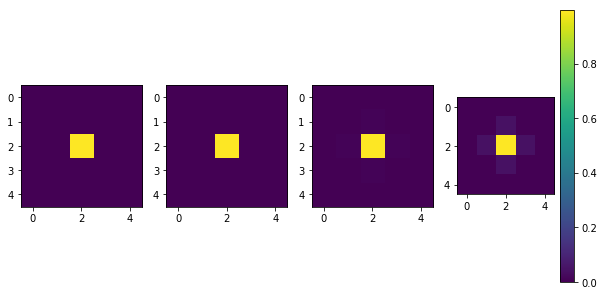

In [18]:
plt = True and nGauss>0
if plt:
    print("Plotting kernels before...")
    import matplotlib.pyplot as plt
    gauss_layer = model.get_layer('gausslayer')
    ws = gauss_layer.get_weights()
    print("Sigmas before",ws[0])
    u_func = K.function(inputs=[model.input], outputs=[gauss_layer.U()])
    output_func = K.function(inputs=[model.input], outputs=[gauss_layer.output])

    U_val=u_func([np.expand_dims(x_test[0], axis=0)])
    
    print("U shape", U_val[0].shape)
    print("U max:", np.max(U_val[0][:,:,:,:]))
    num_filt=min(U_val[0].shape[2],12)
    fig=plt.figure(figsize=(10,5))
    for i in range(num_filt):
        ax1=plt.subplot(1, num_filt, i+1)
        im = ax1.imshow(np.squeeze(U_val[0][:,:,i,0]))
    fig.colorbar(im, ax=ax1)
    plt.show()

In [19]:
from lr_multiplier import LearningRateMultiplier

multipliers = {'gausslayer': 2.0}
opt = LearningRateMultiplier(SGD, lr_multipliers=multipliers, 
                             lr=0.01, momentum=0.9,decay=0.000005000)
# Higher decays hurt the process
print(opt)
#opt = SGD(lr=0.01,momentum=0.5)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=opt,
              metrics=['accuracy'])

batch_size = 128

epochs = 200

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Train on 60000 samples, validate on 10000 samples
Epoch 1/200
60000/60000 [==============================] - 5s 89us/step - loss: 0.2802 - acc: 0.9159 - val_loss: 0.0656 - val_acc: 0.9797
Epoch 2/200
60000/60000 [==============================] - 5s 77us/step - loss: 0.1057 - acc: 0.9672 - val_loss: 0.0500 - val_acc: 0.9845
Epoch 3/200
60000/60000 [==============================] - 5s 77us/step - loss: 0.0842 - acc: 0.9741 - val_loss: 0.0366 - val_acc: 0.9881
Epoch 4/200
60000/60000 [==============================] - 5s 77us/step - loss: 0.0694 - acc: 0.9778 - val_loss: 0.0313 - val_acc: 0.9899
Epoch 5/200
60000/60000 [==============================] - 5s 77us/step - loss: 0.0603 - acc: 0.9815 - val_loss: 0.0299 - val_acc: 0.9918
Epoch 6/200
60000/60000 [==============================] - 5s 79us/step - loss: 0.0536 - acc: 0.9835 - val_loss: 0.0278 - val_acc: 0.9913
Epoch 7/200
60000/60000 [==============================] - 5s 79us/step - loss: 0.0491 - acc: 0.9842 - val_loss: 0.0290 - 

Plotting kernels after ...
U max: 1.0
Sigmas after [ 0.04040195 -0.          0.9171165   0.3766555 ]
U shape (5, 5, 4, 1)


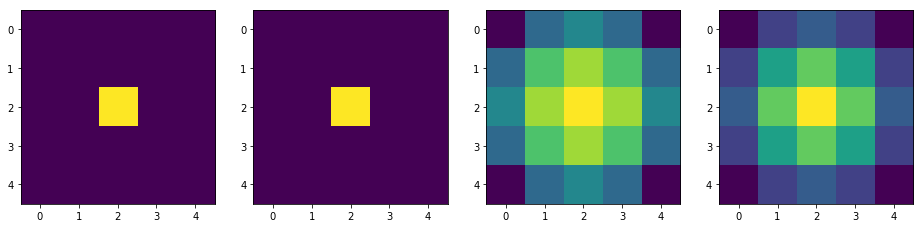

outputs  ...
Outputs shape (1, 28, 28, 4)
input mean,var,max 0.06930272 0.054472942 0.99607843
ouput mean,var,max 0.06930272 0.054472942 0.99607843
ouput mean,var,max 0.06930272 0.054472942 0.99607843
ouput mean,var,max 0.34520313 0.6071919 3.1693373
ouput mean,var,max 0.3105209 0.5663452 3.300778


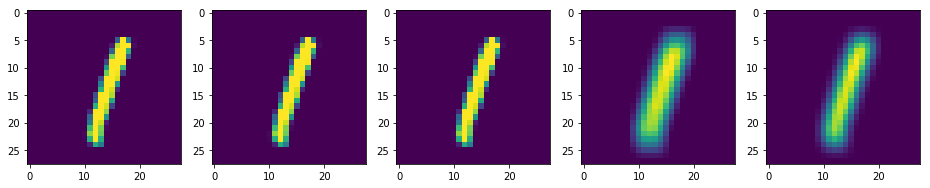

In [20]:
if plt:
    print("Plotting kernels after ...")
    
    print("U max:", np.max(U_val[0][:,:,:,:]))
    import matplotlib.pyplot as plt
    ws = gauss_layer.get_weights()
    print("Sigmas after",ws[0])
    U_val=u_func([np.expand_dims(x_test[2], axis=0)])
    
    print("U shape", U_val[0].shape)
    num_filt=min(U_val[0].shape[2],12)
    fig=plt.figure(figsize=(16,5))
    for i in range(num_filt):
        ax=plt.subplot(1, num_filt, i+1)
        im = ax.imshow(np.squeeze(U_val[0][:,:,i,0]))
    #fig.colorbar(im, ax=ax1)
    plt.show()
    
    
    print("outputs  ...")
    
    n=5
    
    out_val=output_func([np.expand_dims(x_test[5], axis=0)])
    print("Outputs shape", out_val[0].shape)
    num_filt=min(out_val[0].shape[3],12)
    fig=plt.figure(figsize=(16,10))
    ax=plt.subplot(1, num_filt+1, 1)
    im = ax.imshow(np.squeeze(x_test[5]))
    print("input mean,var,max",np.mean(x_test[5]),np.var(x_test[5]),np.max(x_test[5]))
    for i in range(num_filt):
        ax=plt.subplot(1, num_filt+1, i+2)
        out_im = out_val[0][0,:,:,i]
        im = ax.imshow(np.squeeze(out_im))
        print("ouput mean,var,max",np.mean(out_im),
                                       np.var(out_im),
                                       np.max(out_im))
        #plt.colorbar(im,ax=ax)
    plt.show()
    
    
    